In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from tensorflow.keras.applications import Xception 
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')  

modules loaded


In [2]:
import os
import pandas as pd

data_dir = r"D:\CAPSTONE 400A\cse438\lung_colon_image_set\lung_image_sets"
filepaths = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        filepaths.append(file_path)
        label = os.path.basename(root)
        labels.append(label)


df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})


print(df)


                                               filepaths    labels
0      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
1      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
2      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
3      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
4      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
...                                                  ...       ...
14995  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc
14996  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc
14997  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc
14998  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc
14999  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc

[15000 rows x 2 columns]


In [3]:
labels = df['labels']
train_df, temp_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=labels)
valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=123, stratify=temp_df['labels']) 

In [4]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)


valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)


test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [5]:
g_dict = train_gen.class_indices

classes = list(g_dict.keys())

images, labels = next(train_gen)
class_count = len(list(train_gen.class_indices.keys()))


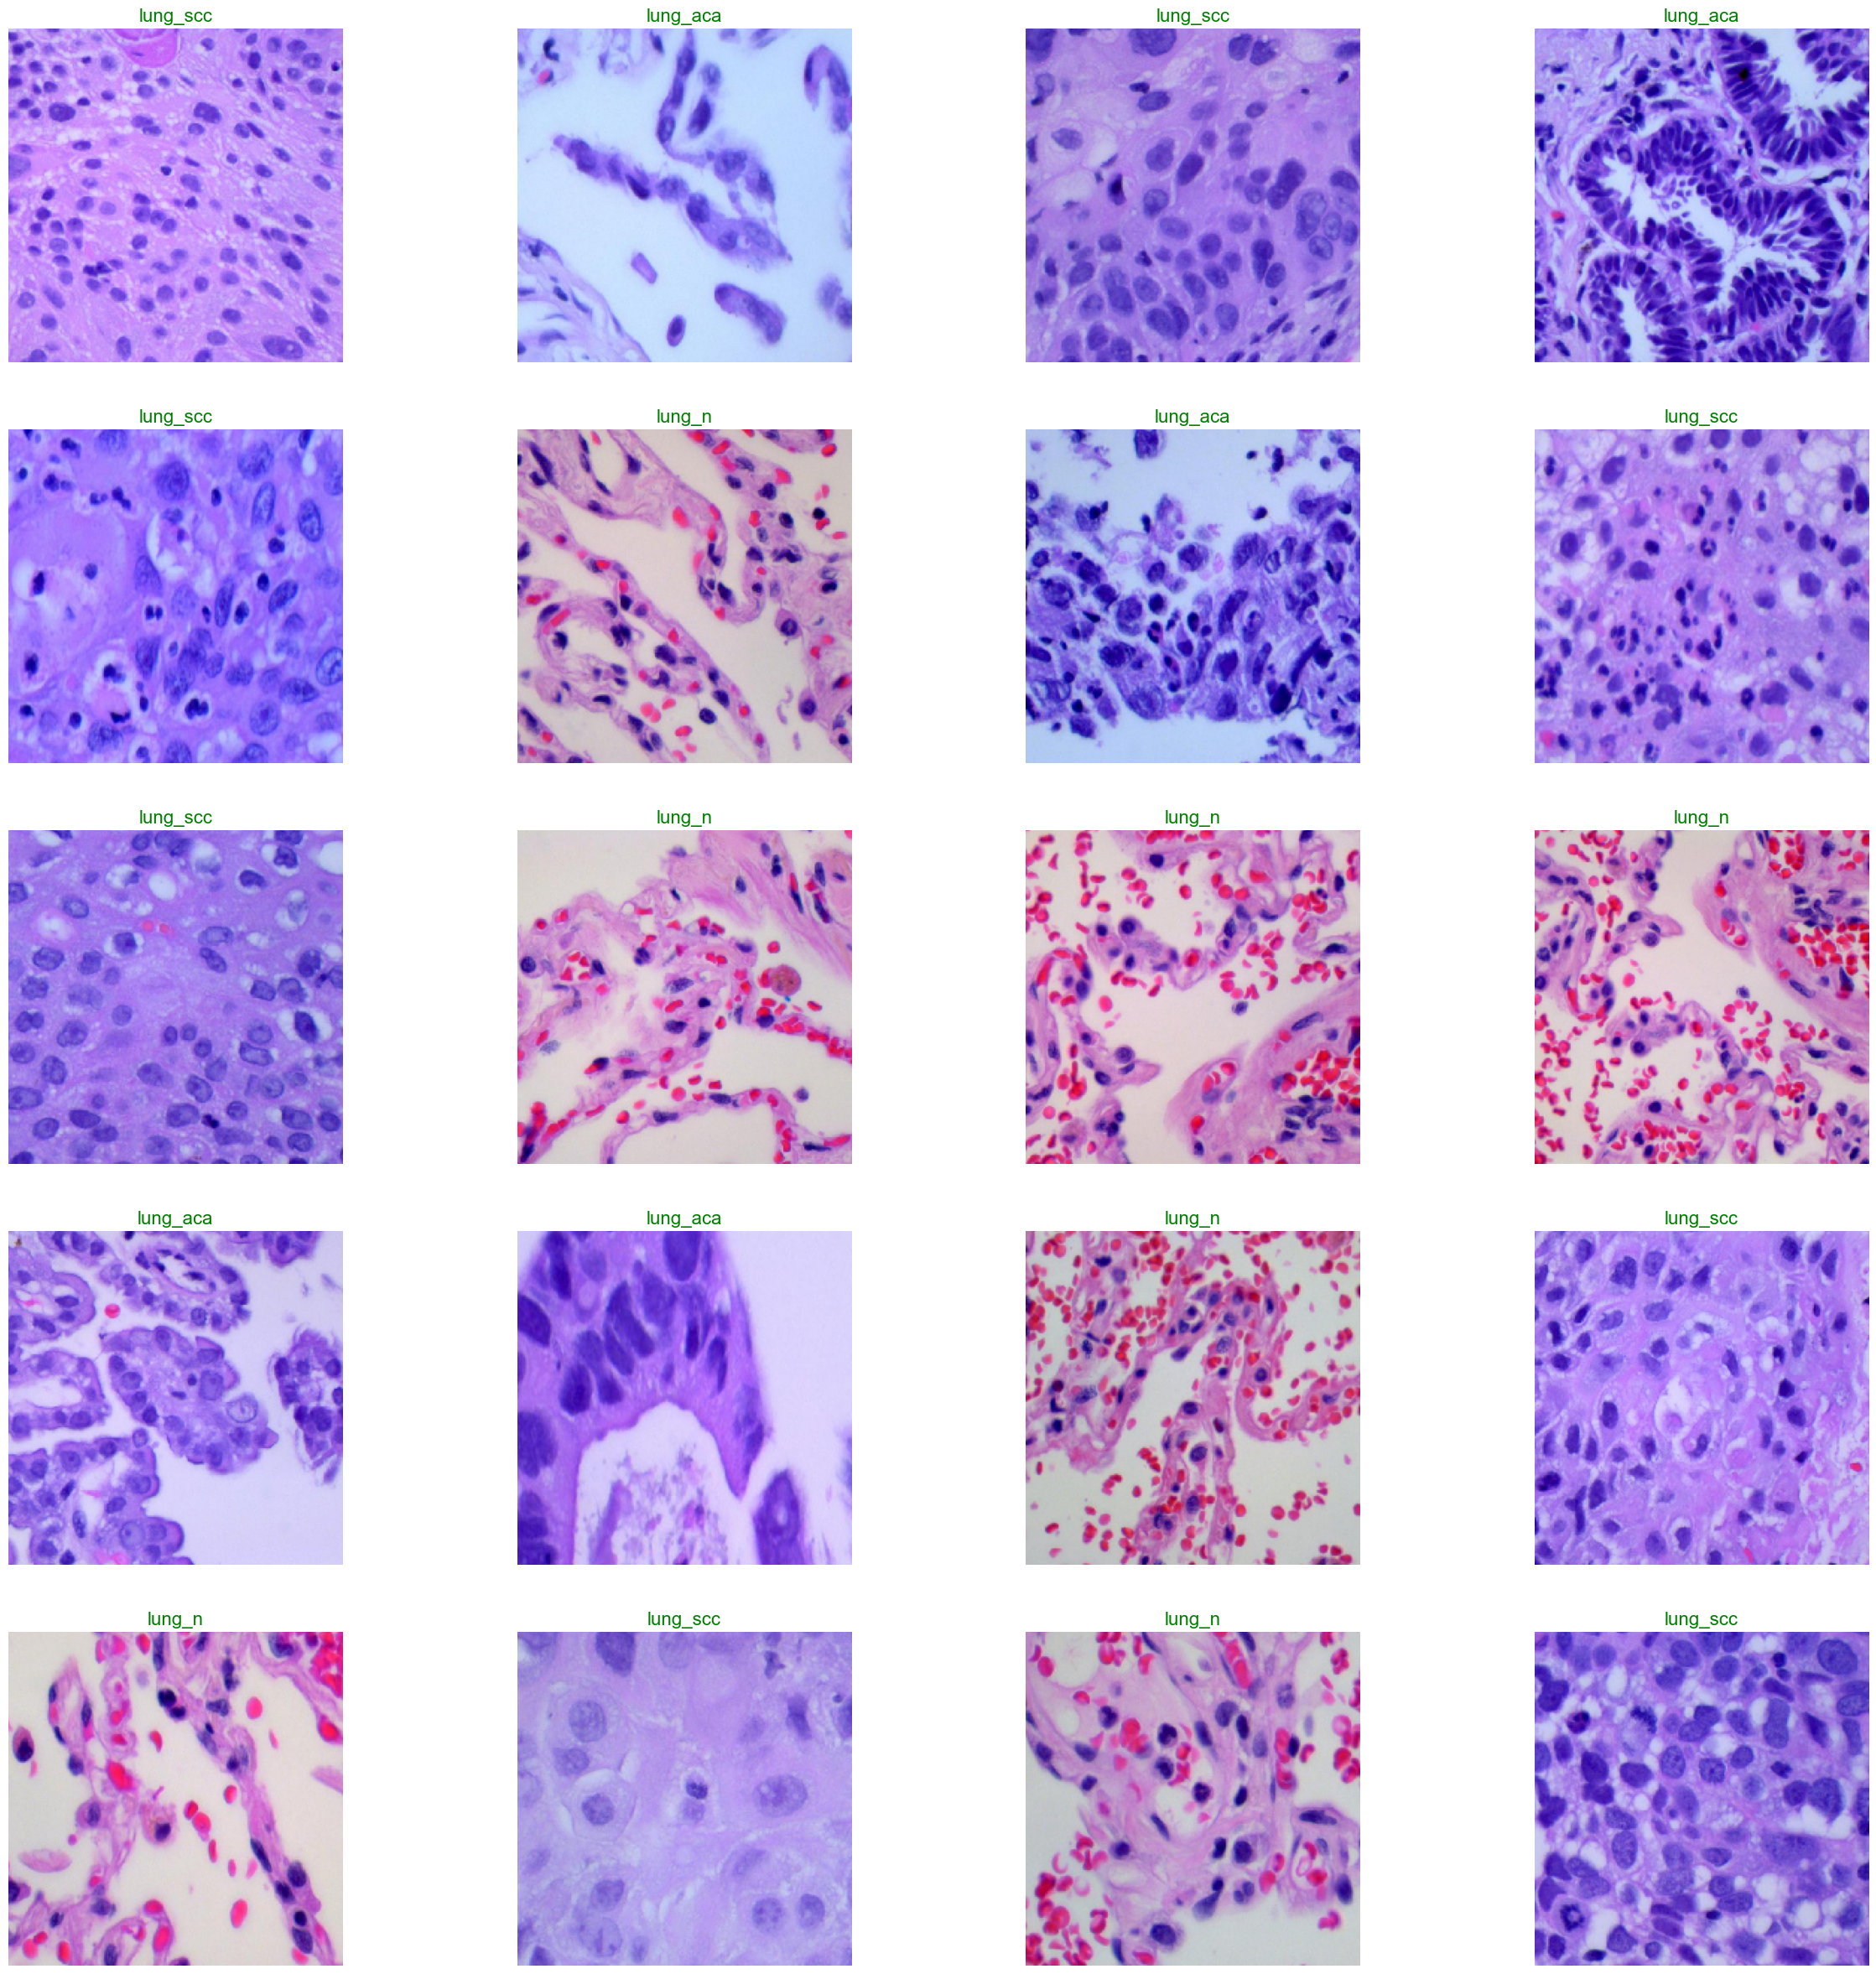

In [6]:
plt.figure(figsize=(30, 30))

for i in range(20):

    plt.subplot(5, 4, i + 1)
    
    image = images[i] / 255 
    
    plt.imshow(image)
    
    index = np.argmax(labels[i])
  
    class_name = classes[index]
    
    plt.title(class_name, color='green', fontsize=16)
    
    plt.axis('off')

plt.show()

In [7]:
def get_callbacks(model_name):
    callbacks = []

    
    checkpoint = ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_accuracy', mode='max') 
    callbacks.append(checkpoint) 

  
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    callbacks.append(reduce_lr)

    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    callbacks.append(early_stopping)

    return callbacks 

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.models import Model 
base_model = Xception(input_shape=img_shape, include_top=False, weights='imagenet')

base_model.trainable = True

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dropout(0.3)(x)
y = Dense(512, activation='relu')(x)

y = Dropout(0.3)(y)

predictions = Dense(class_count, activation='softmax', name='final')(y)

model_Xception = Model(inputs=base_model.input, outputs=predictions)  


model_Xception.compile(optimizer=Adamax(0.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
epochs=1

callbacks=get_callbacks('Xception') 
history_Xception=model_Xception.fit(train_gen,
                                    epochs=epochs,
                                    validation_data=valid_gen,
                                    callbacks=[callbacks])

 34/375 [=>............................] - ETA: 2:42:00 - loss: 0.2557 - accuracy: 0.9200

In [ ]:
ts_length = len(test_df)

test_batch_size = min(32, ts_length)
test_steps = ts_length // test_batch_size

train_score = model_Xception.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model_Xception.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model_Xception.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1]) 
print('-' * 20)
print("Test Loss: ", test_score[0]) 
print("Test Accuracy: ", test_score[1]) 

In [ ]:
tr_acc = history_Xception.history['accuracy']
tr_loss = history_Xception.history['loss']
val_acc = history_Xception.history['val_accuracy']
val_loss = history_Xception.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}' 


plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
preds = model_Xception.predict_generator(test_gen)
y_pred_Xception = np.argmax(preds, axis=1)   

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())


cm = confusion_matrix(test_gen.classes, y_pred_Xception)

plt.figure(figsize= (20, 20))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'green' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
 
plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred_Xception, target_names= classes))   